Mounting drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing packages

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
from collections import Counter
import nltk
nltk.download('stopwords')
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Reading in dataset

In [ ]:
directory = '/content/drive/MyDrive/WPI/Senior Year/NLP/CS525/yelp_food_reviews.pkl'
df = pd.read_pickle(directory)
df.head()

,business_id,stars,useful,funny,cool,text,visits,visits_normalized,label
0,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",177.0,35.400000,1.0
3,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",204.0,18.545455,1.0
5,04UD14gamNjLY0IDYVhHJg,1.0,1,2,1,I am a long term frequent customer of this est...,290.0,24.166667,1.0
7,LHSTtnW3YHCeUkRDGyJOyw,5.0,2,0,0,Amazingly amazing wings and homemade bleu chee...,84.0,12.000000,0.0
9,gebiRewfieSdtt17PTW6Zg,3.0,0,0,0,Had a party of 6 here for hibachi. Our waitres...,1050.0,87.500000,2.0


In [ ]:
def sentiment(val):
  if val >= 3:
    return 1
  else:
    return 0

Using only a subset

In [ ]:
subset = df[['text','stars']].sample(n=10000, random_state=8)
subset['stars'] = subset['stars'].apply(lambda x: sentiment(x))
subset.head()

,text,stars
4926291,My husband & I LOVE Old Castle. It's one of ou...,1
6032203,"Loved it here! The food was so delicious, lite...",1
1243368,"Take out order for dinner with family tonight,...",1
2410403,Went for a simple steak dinner with a business...,1
5174983,Had a very disappointing experience at Trailhe...,0


Splitting into training and testing

In [ ]:
X,y = subset['text'].values, subset['stars'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (7500,)
shape of test data is (2500,)


Counts of each star

In [ ]:
pd.Series(y_train).value_counts()

1    5931
0    1569
dtype: int64

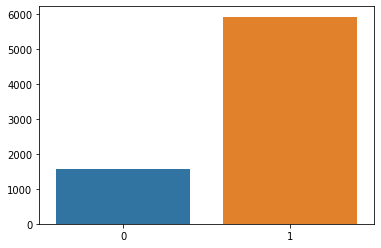

In [ ]:
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array([1,0]),y=dd.values)
plt.show()

Review Preprocessing

In [ ]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

def tockenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:len(word_list)]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                    if preprocess_string(word) in onehot_dict.keys()])
            
    #encoded_train = [1 if label =='positive' else 0 for label in y_train]  
    #encoded_test = [1 if label =='positive' else 0 for label in y_val] 
    return np.array(final_list_train), np.array(y_train),np.array(final_list_test), np.array(y_test), onehot_dict

In [ ]:
x_train,y_train,x_test,y_test,vocab = tockenize(x_train,y_train,x_test,y_test)

<ipython-input-7-34e8be5549ef>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(final_list_train), np.array(y_train),np.array(final_list_test), np.array(y_test), onehot_dict


In [ ]:
print(f'Length of vocabulary is {len(vocab)}')
print(type(x_train))

Length of vocabulary is 22466
<class 'numpy.ndarray'>


Analyzing review length


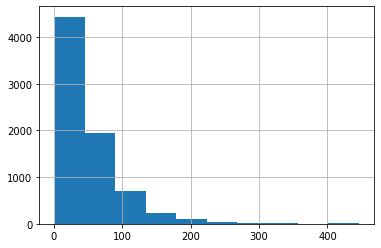

count    7500.000000
mean       51.765467
std        46.356628
min         1.000000
25%        22.000000
50%        37.000000
75%        66.000000
max       446.000000
dtype: float64

In [ ]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

Adding Padding

In [ ]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [ ]:
x_train_pad = padding_(x_train,500)
x_test_pad = padding_(x_test,500)

In [ ]:
len(x_train_pad[5])

500

Batching and loading as Tensor for TensorFlow

In [ ]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [ ]:
train_data[0][0].shape

torch.Size([500])

In [ ]:
class RatingRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(RatingRNN,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
    
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
          # dropout layer
        self.dropout = nn.Dropout(0.3)
    
        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()

    def forward(self,x,hidden):
          batch_size = x.size(0)
          # embeddings and lstm_out
          embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
          #print(embeds.shape)  #[50, 500, 1000]
          lstm_out, hidden = self.lstm(embeds, hidden)
        
          lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
          # dropout and fully connected layer
          out = self.dropout(lstm_out)
          out = self.fc(out)
        
          # sigmoid function
          sig_out = self.sig(out)
        
          # reshape to be batch_size first
          sig_out = sig_out.view(batch_size, -1)

          sig_out = sig_out[:, -1] # get last batch of labels
        
          # return last sigmoid output and hidden state
          return sig_out, hidden
    def init_hidden(self, batch_size):
          ''' Initializes hidden state '''
          # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
          # initialized to zero, for hidden state and cell state of LSTM
          h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim))
          c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim))
          hidden = (h0,c0)
          return hidden


      

In [ ]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256


model = RatingRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

#moving to gpu
#model.to(device)

print(model)

RatingRNN(
  (embedding): Embedding(22126, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [ ]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [ ]:
clip = 5
epochs = 5 
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state 
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        
        inputs, labels = inputs, labels 
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        print(inputs)
        model.zero_grad()
        output,h = model(inputs,h)
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
 
    
        
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs, labels

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), 'state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')

tensor([[    0,     0,     0,  ...,   222,    34,     9],
        [    0,     0,     0,  ...,  1723,  7194,    25],
        [    0,     0,     0,  ...,   135,    24,   102],
        ...,
        [    0,     0,     0,  ...,   790,   485,    81],
        [    0,     0,     0,  ...,   110, 17375,  1369],
        [    0,     0,     0,  ...,   515,   325,   706]])
